In [1]:
# Record the start time
import time
start = time.time()
start

1706546368.9222748

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, ConfusionMatrixDisplay, recall_score, precision_score

from imblearn.over_sampling import SMOTE
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('fraud_oracle.csv')

# EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

In [6]:
df.isnull().sum()

Month                   0
WeekOfMonth             0
DayOfWeek               0
Make                    0
AccidentArea            0
DayOfWeekClaimed        0
MonthClaimed            0
WeekOfMonthClaimed      0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
FraudFound_P            0
PolicyNumber            0
RepNumber               0
Deductible              0
DriverRating            0
Days_Policy_Accident    0
Days_Policy_Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange_Claim     0
NumberOfCars            0
Year                    0
BasePolicy              0
dtype: int64

In [8]:
# Check DayOfWeekClaimed == 0
df[df['DayOfWeekClaimed']=='0']

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
1516,Jul,2,Monday,Honda,Rural,0,0,1,Male,Single,0,Policy Holder,Sedan - All Perils,Sedan,more than 69000,0,1517,15,400,2,more than 30,none,none,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,All Perils


In [10]:
# Check Age == 0
print(df[df['Age']==0].shape)
df[df['Age']==0].sample(3)

(320, 33)


,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
9461,Jul,1,Friday,Honda,Urban,Tuesday,Jul,1,Male,Single,0,Policy Holder,Sedan - Liability,Sport,more than 69000,0,9462,7,400,3,more than 30,more than 30,2 to 4,new,16 to 17,No,No,External,none,no change,1 vehicle,1995,Liability
1945,Jan,2,Friday,Honda,Urban,Thursday,Jan,3,Male,Single,0,Policy Holder,Sedan - All Perils,Sedan,more than 69000,0,1946,3,400,3,more than 30,more than 30,none,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,All Perils
1954,Dec,3,Friday,Honda,Urban,Tuesday,Jan,1,Male,Single,0,Policy Holder,Sedan - Collision,Sedan,more than 69000,0,1955,8,400,3,more than 30,more than 30,none,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,Collision


In [11]:
df = df.drop(columns='PolicyNumber')

## Cleansing

In [12]:
df = df[~(df['MonthClaimed']=='0')]

In [13]:
df[df['Age']==0]['AgeOfPolicyHolder'].unique() 
df['Age'] =df['Age'].replace({0:16.5})

In [14]:
df = df.drop(columns='PolicyType')

## Encode Categorical Data

In [15]:
col_ordering = [
    {'col':'AccidentArea','mapping':{'Urban':1, 'Rural':0}},
    {'col':'Sex','mapping':{'Female':1, 'Male':0}},
    {'col':'Fault','mapping':{'Policy Holder':1, 'Third Party':0}},
    {'col':'PoliceReportFiled','mapping':{'Yes':1, 'No':0}},
    {'col':'WitnessPresent','mapping':{'Yes':1, 'No':0}},
    {'col':'AgentType','mapping':{'External':1, 'Internal':0}},
    {'col':'Month','mapping':{'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}},
    {'col':'DayOfWeek','mapping':{'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}},
    {'col':'DayOfWeekClaimed','mapping':{'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}},
    {'col':'MonthClaimed','mapping':{'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}},
    {'col':'PastNumberOfClaims','mapping':{'none':0 ,'1':1,'2 to 4':2,'more than 4':3 }},
    {'col':'NumberOfSuppliments','mapping':{'none':0,'1 to 2':1,'3 to 5':2,'more than 5':3}}, 
    {'col':'VehiclePrice','mapping':{'less than 20000':0,'20000 to 29000':1,'30000 to 39000':2,
                                     '40000 to 59000':3,'60000 to 69000':4,'more than 69000':5}},
    {'col':'AgeOfVehicle','mapping':{'3 years':3,'6 years':6,'7 years':7,'more than 7':8,'5 years':5,'new':0,'4 years':4,'2 years':2}},
    {'col':'Days_Policy_Accident','mapping':{'more than 30':4,'15 to 30':3,'none':0,'1 to 7':1,'8 to 15':2}},
    {'col':'Days_Policy_Claim','mapping':{'more than 30':4,'15 to 30':3,'none':0,'1 to 7':1,'8 to 15':2}},
    {'col':'AgeOfPolicyHolder','mapping':{'16 to 17':1,'18 to 20':2,'21 to 25':3,'26 to 30':4,'31 to 35':5,'36 to 40':6,
                                          '41 to 50':7,'51 to 65':8,'over 65':9}},
    {'col':'AddressChange_Claim','mapping':{'no change':0,'under 6 months':1,'1 year':2,'2 to 3 years':3,'4 to 8 years':4}},
    {'col':'NumberOfCars','mapping':{'1 vehicle':1,'2 vehicles':2,'3 to 4':3,'5 to 8':4,'more than 8':5}}
]
ord_encoder = OrdinalEncoder(mapping = col_ordering, return_df=True)

In [16]:
df2 = ord_encoder.fit_transform(df)

In [17]:
OHE = OneHotEncoder(cols = ['Make','MaritalStatus','VehicleCategory','BasePolicy'],use_cat_names=True, return_df=True) 
df3 = OHE.fit_transform(df2)

In [18]:
df3.head()

,Month,WeekOfMonth,DayOfWeek,Make_Honda,Make_Toyota,Make_Ford,Make_Mazda,Make_Chevrolet,Make_Pontiac,Make_Accura,Make_Dodge,Make_Mercury,Make_Jaguar,Make_Nisson,Make_VW,Make_Saab,Make_Saturn,Make_Porche,Make_BMW,Make_Mecedes,Make_Ferrari,Make_Lexus,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus_Single,MaritalStatus_Married,MaritalStatus_Widow,MaritalStatus_Divorced,Age,Fault,VehicleCategory_Sport,VehicleCategory_Utility,VehicleCategory_Sedan,VehiclePrice,FraudFound_P,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy_Liability,BasePolicy_Collision,BasePolicy_All Perils
0,12,5,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,1,1,1,1,0,0,0,21.0,1,1,0,0,5,0,12,300,1,4,4,0,3,4,0,0,1,0,2,3,1994,1,0,0
1,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,4,0,1,0,0,0,34.0,1,1,0,0,5,0,15,400,4,4,4,0,6,5,1,0,1,0,0,1,1994,0,1,0
2,10,5,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,11,2,0,0,1,0,0,47.0,1,1,0,0,5,0,7,400,3,4,4,1,7,7,0,0,1,0,0,1,1994,0,1,0
3,6,2,6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,7,1,0,0,1,0,0,65.0,0,1,0,0,1,0,4,400,2,4,4,1,8,8,1,0,1,3,0,1,1994,1,0,0
4,1,5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,2,1,1,0,0,0,27.0,0,1,0,0,5,0,3,400,1,4,4,0,5,5,0,0,1,0,0,1,1994,0,1,0


# Split Data

In [19]:
X = df3.drop(columns='FraudFound_P')
y = df3['FraudFound_P']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=48, stratify=y)

X_train = X_train.drop(columns=['Days_Policy_Claim','DayOfWeek','WitnessPresent','WeekOfMonthClaimed','DayOfWeekClaimed','DriverRating','WeekOfMonth','NumberOfCars','RepNumber'])
X_test = X_test.drop(columns=['Days_Policy_Claim','DayOfWeek','WitnessPresent','WeekOfMonthClaimed','DayOfWeekClaimed','DriverRating','WeekOfMonth','NumberOfCars','RepNumber'])

In [21]:

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12335 entries, 14656 to 10666
Data columns (total 46 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    12335 non-null  int32  
 1   Make_Honda               12335 non-null  int64  
 2   Make_Toyota              12335 non-null  int64  
 3   Make_Ford                12335 non-null  int64  
 4   Make_Mazda               12335 non-null  int64  
 5   Make_Chevrolet           12335 non-null  int64  
 6   Make_Pontiac             12335 non-null  int64  
 7   Make_Accura              12335 non-null  int64  
 8   Make_Dodge               12335 non-null  int64  
 9   Make_Mercury             12335 non-null  int64  
 10  Make_Jaguar              12335 non-null  int64  
 11  Make_Nisson              12335 non-null  int64  
 12  Make_VW                  12335 non-null  int64  
 13  Make_Saab                12335 non-null  int64  
 14  Make_Saturn       

In [22]:
y_train.value_counts()


0    11597
1      738
Name: FraudFound_P, dtype: int64

# Five Base Models (DT, MLP, LR, NB, KNN)

##################################################
Decision Tree - Results 
Accuracy: 0.8888
Recall: 0.3189
Specificity: 0.9251
F1-Score: 0.2560
Confusion Matrix:


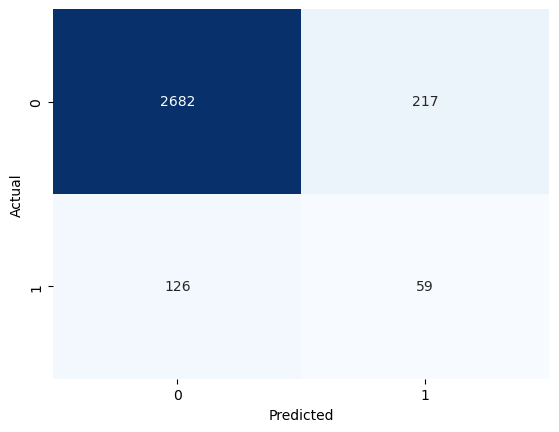

--------------------------------------------------

##################################################
KNN - Results 
Accuracy: 0.9303
Recall: 0.0649
Specificity: 0.9855
F1-Score: 0.1004
Confusion Matrix:


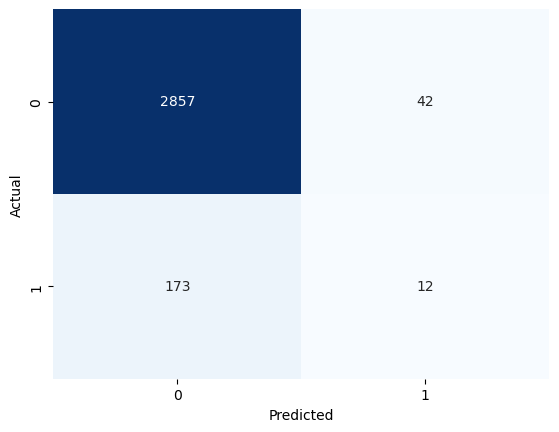

--------------------------------------------------

##################################################
NB - Results 
Accuracy: 0.5778
Recall: 0.8865
Specificity: 0.5581
F1-Score: 0.2012
Confusion Matrix:


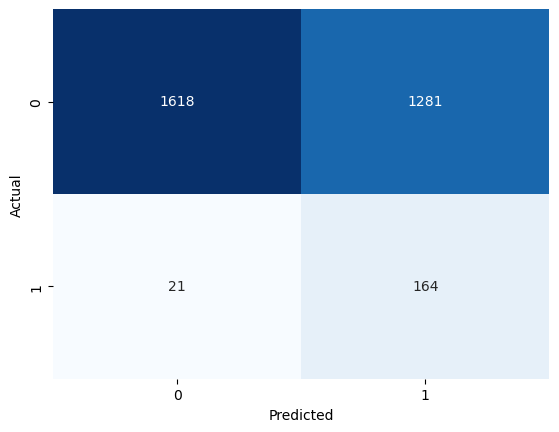

--------------------------------------------------

##################################################
MLP - Results 
Accuracy: 0.9400
Recall: 0.0000
Specificity: 1.0000
F1-Score: 0.0000
Confusion Matrix:


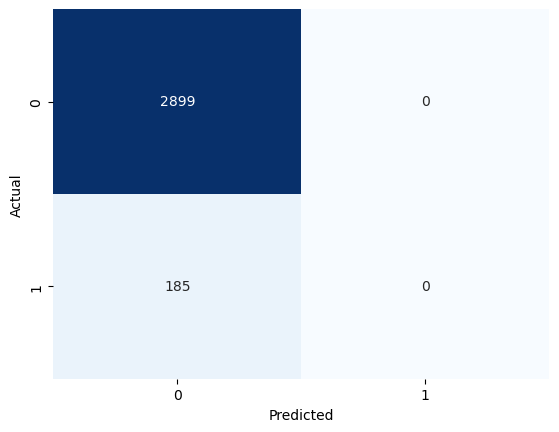

--------------------------------------------------

##################################################
LR - Results 
Accuracy: 0.9400
Recall: 0.0000
Specificity: 1.0000
F1-Score: 0.0000
Confusion Matrix:


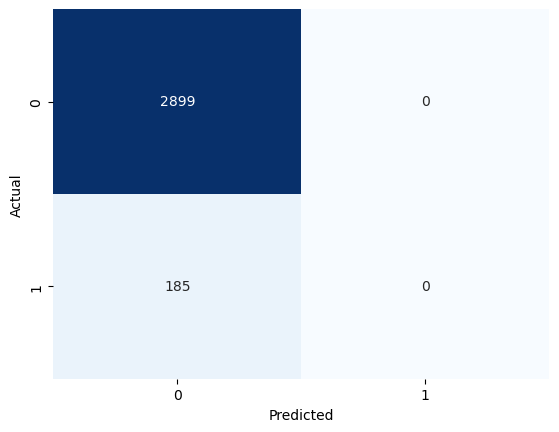

--------------------------------------------------



In [25]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

def evaluate_classifier(name, classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
   

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    true_negative = conf_matrix[0, 0]
    false_positive = conf_matrix[0, 1]
    specificity = true_negative / (true_negative + false_positive)
    f1 = f1_score(y_test, y_pred)

    print("#" * 50)
    print(f"{name} - Results ")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("Confusion Matrix:")
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    print("-" * 50)
    print()

# Decision Tree
dt_classifier = DecisionTreeClassifier(random_state=42)
evaluate_classifier("Decision Tree", dt_classifier, X_train, y_train, X_test, y_test)

# KNN
knn = KNeighborsClassifier(n_neighbors=3)
evaluate_classifier("KNN", knn, X_train, y_train, X_test, y_test)

# Naive Bayes
nb_classifier = GaussianNB()
evaluate_classifier("NB", nb_classifier, X_train, y_train, X_test, y_test)

# MLP
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
evaluate_classifier("MLP", mlp_classifier, X_train, y_train, X_test, y_test)

# Logistic Regression
lr_classifier = LogisticRegression(random_state=42)
evaluate_classifier("LR", lr_classifier, X_train, y_train, X_test, y_test)


# Decision Tree

In [26]:
from imblearn.under_sampling import RandomUnderSampler

def apply_smote(X_train, y_train, X_test, y_test, oversample_percentage, classifier):
    class_0 = int(len(y_train[y_train == 0]))
    class_1 = int(len(y_train[y_train == 1]))

    smote = SMOTE(sampling_strategy={0: class_0, 1: round(class_0 * oversample_percentage)}, random_state=42)
    x_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    classifier.fit(x_train_smote, y_train_smote)

    y_pred = classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    conf_matrix = confusion_matrix(y_test, y_pred)
    true_negative = conf_matrix[0, 0]
    false_positive = conf_matrix[0, 1]
    specificity = true_negative / (true_negative + false_positive)
    f1 = f1_score(y_test, y_pred)

    return accuracy, recall, specificity, f1

def apply_random_undersampling(X_train, y_train, X_test, y_test, undersample_percentage, classifier):
    class_0 = int(len(y_train[y_train == 0]))
    class_1 = int(len(y_train[y_train == 1]))

    undersampler = RandomUnderSampler(sampling_strategy={0: round(class_1 / undersample_percentage), 1: class_1}, random_state=42)
    x_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

    classifier.fit(x_train_undersampled, y_train_undersampled)

    y_pred = classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    conf_matrix = confusion_matrix(y_test, y_pred)
    true_negative = conf_matrix[0, 0]
    false_positive = conf_matrix[0, 1]
    specificity = true_negative / (true_negative + false_positive)
    f1 = f1_score(y_test, y_pred)

    return accuracy, recall, specificity, f1

def plot_results(percentages, accuracies, recalls, specificities, f1_scores, title):
    plt.plot(percentages, accuracies, marker='o', label='Accuracy')
    plt.plot(percentages, recalls, marker='o', label='Recall')
    plt.plot(percentages, specificities, marker='o', label='Specificity')
    plt.plot(percentages, f1_scores, marker='o', label='F1-Score')
    plt.title(title)
    plt.xlabel('Percentage')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()


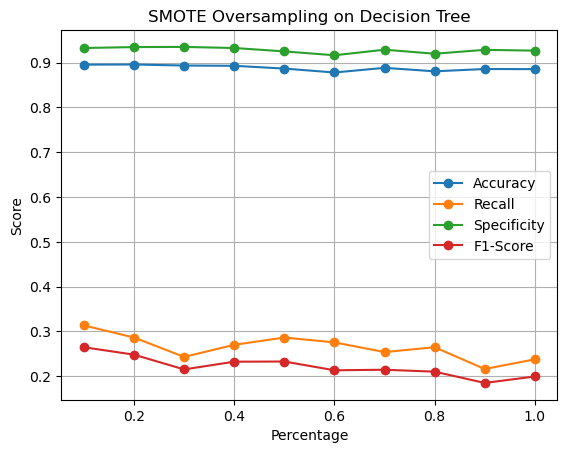

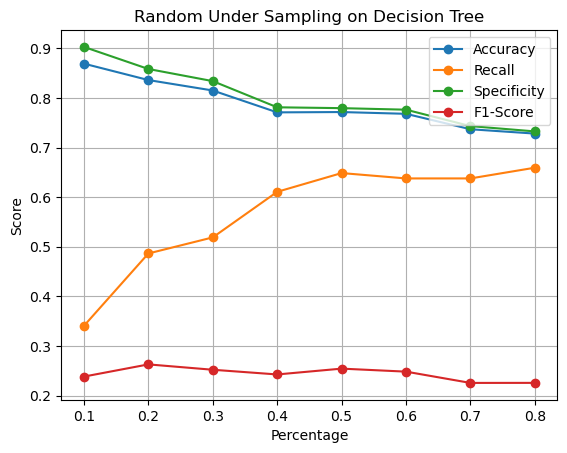

In [27]:
# DT SMOTE
oversampling_percentages = np.arange(0.1, 1.1, 0.1)
accuracies, recalls, specificities, f1_scores = [], [], [], []
dt_classifier = DecisionTreeClassifier(random_state=42)

for oversample_percentage in oversampling_percentages:
    accuracy, recall, specificity, f1 = apply_smote(X_train, y_train, X_test, y_test, oversample_percentage, dt_classifier)
    accuracies.append(accuracy)
    recalls.append(recall)
    specificities.append(specificity)
    f1_scores.append(f1)

plot_results(oversampling_percentages, accuracies, recalls, specificities, f1_scores, 'SMOTE Oversampling on Decision Tree')

# DT Under Sampling
undersampling_percentages = np.arange(0.1, 0.9, 0.1)
accuracies, recalls, specificities, f1_scores = [], [], [], []

for undersample_percentage in undersampling_percentages:
    accuracy, recall, specificity, f1 = apply_random_undersampling(X_train, y_train, X_test, y_test, undersample_percentage, dt_classifier)
    accuracies.append(accuracy)
    recalls.append(recall)
    specificities.append(specificity)
    f1_scores.append(f1)

plot_results(undersampling_percentages, accuracies, recalls, specificities, f1_scores, 'Random Under Sampling on Decision Tree')

Start of hybrid

In [28]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, f1_score

oversampling_percentages = np.arange(0.1, 1.1, 0.1)
undersampling_percentages = np.arange(0.1, 0.9, 0.1)

results_df = pd.DataFrame(columns=['Oversampling', 'Undersampling', 'Accuracy', 'Recall', 'Specificity', 'F1-Score'])

best_combination = None
best_recall = 0
best_accuracy = 0
best_specificity = 0
best_f1 = 0

class_0 = int(len(y_train[y_train == 0]))
class_1 = int(len(y_train[y_train == 1]))

for oversample_percentage in oversampling_percentages:
    smote = SMOTE(sampling_strategy={0: class_0, 1: round(class_0 * oversample_percentage)}, random_state=42)
    x_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    class_1_first = int(len(y_train_smote[y_train_smote == 1]))

    for undersample_percentage in undersampling_percentages:
        undersampler = RandomUnderSampler(sampling_strategy={0: round(class_1 / undersample_percentage), 1: class_1_first}, random_state=42)
        x_train_hybrid, y_train_hybrid = undersampler.fit_resample(x_train_smote, y_train_smote)

        dt_classifier = DecisionTreeClassifier(random_state=42)
        dt_classifier.fit(x_train_hybrid, y_train_hybrid)

        y_pred = dt_classifier.predict(X_test)

        recall = recall_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)

        conf_matrix = confusion_matrix(y_test, y_pred)
        true_negative = conf_matrix[0, 0]
        false_positive = conf_matrix[0, 1]
        specificity = true_negative / (true_negative + false_positive)
        
        f1 = f1_score(y_test, y_pred)

        if recall > best_recall:
            best_recall = recall
            best_accuracy = accuracy
            best_specificity = specificity
            best_f1 = f1
            best_combination = (oversample_percentage, undersample_percentage)
        
        print(f'Oversampling Percentage: {oversample_percentage * 100}%')
        print(f'Undersampling Percentage: {undersample_percentage * 100}%')
        print(f'Recall: {recall:.4f}')
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Specificity: {specificity:.4f}')
        print(f'F1-Score: {f1:.4f}')
        print('-' * 30)

        results_df = results_df.append({
            'Oversampling': oversample_percentage,
            'Undersampling': undersample_percentage,
            'Accuracy': accuracy,
            'Recall': recall,
            'Specificity': specificity,
            'F1-Score': f1
        }, ignore_index=True)

print(f'Best Combination: Oversample {best_combination[0] * 100}%, Undersample {best_combination[1] * 100}%')
print(f'Best Recall: {best_recall:.4f}')
print(f'Best Accuracy: {best_accuracy:.4f}')
print(f'Best Specificity: {best_specificity:.4f}')
print(f'Best F1: {best_f1:.4f}')

results_df.to_csv('results_hyridDT.csv', index=False)

Oversampling Percentage: 10.0%
Undersampling Percentage: 10.0%
Recall: 0.3405
Accuracy: 0.8826
Specificity: 0.9172
F1-Score: 0.2582
------------------------------
Oversampling Percentage: 10.0%
Undersampling Percentage: 20.0%
Recall: 0.4811
Accuracy: 0.8372
Specificity: 0.8600
F1-Score: 0.2618
------------------------------
Oversampling Percentage: 10.0%
Undersampling Percentage: 30.000000000000004%
Recall: 0.5243
Accuracy: 0.8022
Specificity: 0.8199
F1-Score: 0.2413
------------------------------
Oversampling Percentage: 10.0%
Undersampling Percentage: 40.0%
Recall: 0.5568
Accuracy: 0.7711
Specificity: 0.7848
F1-Score: 0.2259
------------------------------
Oversampling Percentage: 10.0%
Undersampling Percentage: 50.0%
Recall: 0.5784
Accuracy: 0.7523
Specificity: 0.7634
F1-Score: 0.2188
------------------------------
Oversampling Percentage: 10.0%
Undersampling Percentage: 60.0%
Recall: 0.6270
Accuracy: 0.7296
Specificity: 0.7361
F1-Score: 0.2176
------------------------------
Oversamp

End of hybrid

In [29]:
# EMSEMBLE BOOSTING
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, f1_score
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt

# Initialize empty lists to store results
oversampling_percentages = np.arange(0.1, 1.1, 0.1)
print(oversampling_percentages)
accuracies = []
recalls = []
specificities = []
f1Scores = []


class_0 = int(len(y_train[y_train == 0]))
class_1 = int(len(y_train[y_train == 1]))
print('*' * 50)
print(class_0)
print(class_1)
print('*' * 50)


print()
print('#' * 30)
print(f'Oversampling Percentage: {oversample_percentage}%')
print(f'Count of 0: {class_0}')
print(f'Count of 1: {class_0 * oversample_percentage}')

x_train_current, y_train_current = X_train, y_train

base_classifier = DecisionTreeClassifier(random_state=42)
xgb_classifier = XGBClassifier(base_classifier=base_classifier, random_state=42)

xgb_classifier.fit(x_train_current, y_train_current)

y_pred = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
accuracies.append(accuracy)

recall = recall_score(y_test, y_pred)
recalls.append(recall)

conf_matrix = confusion_matrix(y_test, y_pred)
true_negative = conf_matrix[0, 0]
false_positive = conf_matrix[0, 1]
specificity = true_negative / (true_negative + false_positive)
specificities.append(specificity)

f1Scores.append(f1_score(y_test, y_pred))

print('#' * 30)
print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'F1-Score: {f1_score(y_test, y_pred):.4f}')
print('-' * 30)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
**************************************************
11597
738
**************************************************

##############################
Oversampling Percentage: 1.0%
Count of 0: 11597
Count of 1: 11597.0
##############################
Accuracy: 0.9384
Recall: 0.0865
Specificity: 0.9928
F1-Score: 0.1441
------------------------------


[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
**************************************************
11597
738
**************************************************

##############################
Oversampling Percentage: 0.1%
Count of 0: 11597
Count of 1: 1159.7
0    11597
1     1160
Name: FraudFound_P, dtype: int64
##############################
Accuracy: 0.9390
Recall: 0.0973
Specificity: 0.9928
F1-Score: 0.1607
------------------------------

##############################
Oversampling Percentage: 0.2%
Count of 0: 11597
Count of 1: 2319.4
0    11597
1     2319
Name: FraudFound_P, dtype: int64
##############################
Accuracy: 0.9351
Recall: 0.1081
Specificity: 0.9879
F1-Score: 0.1667
------------------------------

##############################
Oversampling Percentage: 0.30000000000000004%
Count of 0: 11597
Count of 1: 3479.1000000000004
0    11597
1     3479
Name: FraudFound_P, dtype: int64
##############################
Accuracy: 0.9332
Recall: 0.1351
Specificity: 0.9841
F1-Score: 0

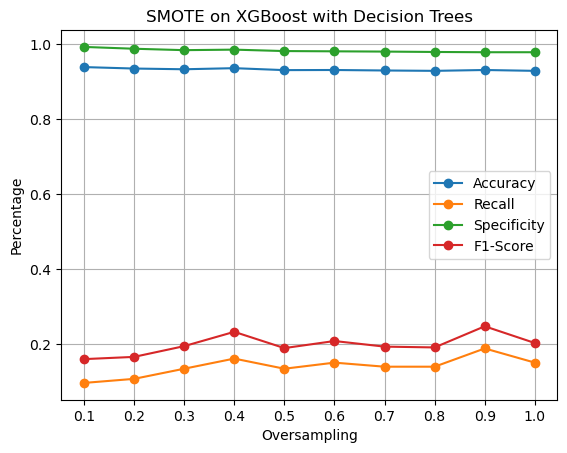

In [30]:
#ENSEMBLE BOOSTING SMOTE
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Initialize empty lists to store results
oversampling_percentages = np.arange(0.1, 1.1, 0.1)
print(oversampling_percentages)
accuracies = []
recalls = []
specificities = []
f1Scores = []

class_0 = int(len(y_train[y_train == 0]))
class_1 = int(len(y_train[y_train == 1]))
print('*' * 50)
print(class_0)
print(class_1)
print('*' * 50)

results_df = pd.DataFrame(columns=['Oversampling', 'Accuracy', 'Recall', 'Specificity', 'F1-Score'])


for oversample_percentage in oversampling_percentages:
    print()
    print('#' * 30)
    print(f'Oversampling Percentage: {oversample_percentage}%')
    print(f'Count of 0: {class_0}')
    print(f'Count of 1: {class_0 * oversample_percentage}')

    smote = SMOTE(sampling_strategy={0: class_0, 1: round(class_0 * oversample_percentage)}, random_state=42)
    x_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    base_classifier = DecisionTreeClassifier(random_state=42)
    xgb_classifier = XGBClassifier(base_classifier=base_classifier, random_state=42)

    xgb_classifier.fit(x_train_smote, y_train_smote)

    y_pred = xgb_classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    recall = recall_score(y_test, y_pred)
    recalls.append(recall)

    conf_matrix = confusion_matrix(y_test, y_pred)
    true_negative = conf_matrix[0, 0]
    false_positive = conf_matrix[0, 1]
    specificity = true_negative / (true_negative + false_positive)
    specificities.append(specificity)

    f1Scores.append(f1_score(y_test, y_pred))

    print(y_train_smote.value_counts())
    print('#' * 30)
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'Specificity: {specificity:.4f}')
    print(f'F1-Score: {f1_score(y_test, y_pred):.4f}')
    print('-' * 30)

    results_df = results_df.append({
        'Oversampling': oversample_percentage,
        'Accuracy': accuracy,
        'Recall': recall,
        'Specificity': specificity,
        'F1-Score': f1_score(y_test, y_pred)
    }, ignore_index=True)

plt.plot(oversampling_percentages, accuracies, marker='o', label='Accuracy')
plt.plot(oversampling_percentages, recalls, marker='o', label='Recall')
plt.plot(oversampling_percentages, specificities, marker='o', label='Specificity')
plt.plot(oversampling_percentages, f1Scores, marker='o', label='F1-Score')
plt.title('SMOTE on XGBoost with Decision Trees')
plt.xlabel('Oversampling')
plt.ylabel('Percentage')
plt.xticks(oversampling_percentages) 
plt.legend()
plt.grid(True)
plt.show()

results_df.to_csv('results_DecisionTree_SMOTE.csv', index=False)


0    11597
1      738
Name: FraudFound_P, dtype: int64
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
**************************************************
11597
738
**************************************************

##############################
Undersampling Percentage: 10.0%
Count of 0: 7380
Count of 1: 738
0    7380
1     738
Name: FraudFound_P, dtype: int64
##############################
Accuracy: 0.9329
Recall: 0.1676
Specificity: 0.9817
F1-Score: 0.2305
------------------------------

##############################
Undersampling Percentage: 20.0%
Count of 0: 3690
Count of 1: 738
0    3690
1     738
Name: FraudFound_P, dtype: int64
##############################
Accuracy: 0.9014
Recall: 0.4054
Specificity: 0.9331
F1-Score: 0.3304
------------------------------

##############################
Undersampling Percentage: 30.000000000000004%
Count of 0: 2460
Count of 1: 738
0    2460
1     738
Name: FraudFound_P, dtype: int64
##############################
Accuracy: 0.8680
Recall: 0.4811
Specificit

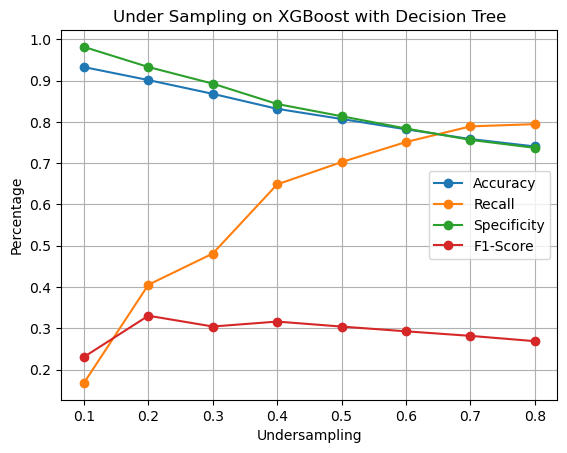

In [31]:
#  ENSEMBLE BOOSTING UNDER
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, f1_score
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

print(y_train.value_counts())

undersampling_percentages = np.arange(0.1, 0.9, 0.1)
print(undersampling_percentages)
accuracies = []
recalls = []
specificities = []
f1Scores = []

class_0 = int(len(y_train[y_train == 0]))
class_1 = int(len(y_train[y_train == 1]))
print('*' * 50)
print(class_0)
print(class_1)
print('*' * 50)

results_df = pd.DataFrame(columns=['Oversampling', 'Accuracy', 'Recall', 'Specificity', 'F1-Score'])

for undersample_percentage in undersampling_percentages:
    print()
    print('#' * 30)
    print(f'Undersampling Percentage: {undersample_percentage * 100}%')
    print(f'Count of 0: {round(class_1 / undersample_percentage)}')
    print(f'Count of 1: {class_1}')

    undersampler = RandomUnderSampler(sampling_strategy={0: round(class_1 / undersample_percentage), 1: class_1}, random_state=42)
    x_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

    base_classifier = DecisionTreeClassifier(random_state=42)
    xgb_classifier = XGBClassifier(base_classifier=base_classifier, random_state=42)

    xgb_classifier.fit(x_train_undersampled, y_train_undersampled)

    y_pred = xgb_classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    recall = recall_score(y_test, y_pred)
    recalls.append(recall)

    conf_matrix = confusion_matrix(y_test, y_pred)
    true_negative = conf_matrix[0, 0]
    false_positive = conf_matrix[0, 1]
    specificity = true_negative / (true_negative + false_positive)
    specificities.append(specificity)

    f1Scores.append(f1_score(y_test, y_pred))

    print(y_train_undersampled.value_counts())
    print('#' * 30)
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'Specificity: {specificity:.4f}')
    print(f'F1-Score: {f1_score(y_test, y_pred):.4f}')
    print('-' * 30)

    results_df = results_df.append({
        'Oversampling': oversample_percentage,
        'Accuracy': accuracy,
        'Recall': recall,
        'Specificity': specificity,
        'F1-Score': f1_score(y_test, y_pred)
    }, ignore_index=True)

# Plotting the results
plt.plot(undersampling_percentages, accuracies, marker='o', label='Accuracy')
plt.plot(undersampling_percentages, recalls, marker='o', label='Recall')
plt.plot(undersampling_percentages, specificities, marker='o', label='Specificity')
plt.plot(undersampling_percentages, f1Scores, marker='o', label='F1-Score')
plt.title('Under Sampling on XGBoost with Decision Tree')
plt.xlabel('Undersampling')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True)
plt.show()

results_df.to_csv('results_DecisionTree_SMOTE2.csv', index=False)


In [32]:
# BOOSTING HYBRID

import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, f1_score
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

# Initialize empty lists to store results
oversampling_percentages = np.arange(0.1, 1.1, 0.1)
undersampling_percentages = np.arange(0.1, 0.9, 0.1)

best_combination = None
best_recall = 0
best_accuracy = 0
best_specificity = 0
best_f1 = 0

results_df = pd.DataFrame(columns=['Oversampling', 'Undersampling', 'Accuracy', 'Recall', 'Specificity', 'F1-Score'])

class_0 = int(len(y_train[y_train == 0]))
class_1 = int(len(y_train[y_train == 1]))

print(y_train.value_counts())

for oversample_percentage in oversampling_percentages:
    smote = SMOTE(sampling_strategy={0: class_0, 1: round(class_0 * oversample_percentage)}, random_state=42)
    x_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    print('*' * 50)
    print(y_train_smote.value_counts())
    print('*' * 50)
    print()

    class_1_first = int(len(y_train_smote[y_train_smote == 1]))

    for undersample_percentage in undersampling_percentages:
        undersampler = RandomUnderSampler(sampling_strategy={0: round(class_1 / undersample_percentage), 1: class_1_first}, random_state=42)
        x_train_hybrid, y_train_hybrid = undersampler.fit_resample(x_train_smote, y_train_smote)
        print('-' * 75)
        print('?' * 50)
        print(y_train_hybrid.value_counts())
        print('?' * 50)
        base_classifier = DecisionTreeClassifier(random_state=42)
        xgb_classifier = XGBClassifier(base_classifier=base_classifier, random_state=42)

        xgb_classifier.fit(x_train_hybrid, y_train_hybrid)

        y_pred = xgb_classifier.predict(X_test)

        recall = recall_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)

        conf_matrix = confusion_matrix(y_test, y_pred)
        true_negative = conf_matrix[0, 0]
        false_positive = conf_matrix[0, 1]
        specificity = true_negative / (true_negative + false_positive)
        f1 = f1_score(y_test, y_pred)

        if f1_score(y_test, y_pred) > best_f1 and recall > best_recall:
            best_recall = recall
            best_accuracy = accuracy
            best_specificity = specificity
            best_f1 = f1_score(y_test, y_pred)
            best_combination = (oversample_percentage, undersample_percentage)

        print(f'Oversampling Percentage: {oversample_percentage * 100}%')
        print(f'Undersampling Percentage: {undersample_percentage * 100}%')
        print(f'Recall: {recall:.4f}')
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Specificity: {specificity:.4f}')
        print(f'F1-Score: {f1:.4f}')

        results_df = results_df.append({
            'Oversampling': oversample_percentage,
            'Undersampling': undersample_percentage,
            'Accuracy': accuracy,
            'Recall': recall,
            'Specificity': specificity,
            'F1-Score': f1
        }, ignore_index=True)

        print('-' * 30)

print(f'Best Combination: Oversample {best_combination[0] * 100}%, Undersample {best_combination[1] * 100}%')
print(f'Best Recall: {best_recall:.4f}')
print(f'Best Accuracy: {best_accuracy:.4f}')
print(f'Best Specificity: {best_specificity:.4f}')
print(f'Best F1: {best_f1:.4f}')

# Save the DataFrame to a CSV file
results_df.to_csv('results_hyridboosting.csv', index=False)


0    11597
1      738
Name: FraudFound_P, dtype: int64
**************************************************
0    11597
1     1160
Name: FraudFound_P, dtype: int64
**************************************************

---------------------------------------------------------------------------
??????????????????????????????????????????????????
0    7380
1    1160
Name: FraudFound_P, dtype: int64
??????????????????????????????????????????????????
Oversampling Percentage: 10.0%
Undersampling Percentage: 10.0%
Recall: 0.1568
Accuracy: 0.9309
Specificity: 0.9803
F1-Score: 0.2140
------------------------------
---------------------------------------------------------------------------
??????????????????????????????????????????????????
0    3690
1    1160
Name: FraudFound_P, dtype: int64
??????????????????????????????????????????????????
Oversampling Percentage: 10.0%
Undersampling Percentage: 20.0%
Recall: 0.3730
Accuracy: 0.8998
Specificity: 0.9334
F1-Score: 0.3087
------------------------------

In [33]:
# EMSEMBLE BAGGING
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingClassifier

# Initialize empty lists to store results
oversampling_percentages = np.arange(0.1, 1.1, 0.1)
print(oversampling_percentages)
accuracies = []
recalls = []
specificities = []
f1Scores = []

class_0 = int(len(y_train[y_train == 0]))
class_1 = int(len(y_train[y_train == 1]))
print('*' * 50)
print(class_0)
print(class_1)
print('*' * 50)


print()
print('#' * 30)
print(f'Oversampling Percentage: {oversample_percentage}%')
print(f'Count of 0: {class_0}')
print(f'Count of 1: {class_0 * oversample_percentage}')



x_train_current, y_train_current = X_train, y_train


base_classifier = DecisionTreeClassifier(random_state=42)
bagging_classifier = BaggingClassifier(base_classifier, n_estimators=10, random_state=42)

bagging_classifier.fit(x_train_current, y_train_current)

y_pred = bagging_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
accuracies.append(accuracy)

recall = recall_score(y_test, y_pred)
recalls.append(recall)

conf_matrix = confusion_matrix(y_test, y_pred)
true_negative = conf_matrix[0, 0]
false_positive = conf_matrix[0, 1]
specificity = true_negative / (true_negative + false_positive)
specificities.append(specificity)

f1Scores.append(f1_score(y_test, y_pred))

# Print the results for each iteration
print('#' * 30)
print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'F1-Score: {f1_score(y_test, y_pred):.4f}')
print('-' * 30)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
**************************************************
11597
738
**************************************************

##############################
Oversampling Percentage: 1.0%
Count of 0: 11597
Count of 1: 11597.0
##############################
Accuracy: 0.9390
Recall: 0.1514
Specificity: 0.9893
F1-Score: 0.2295
------------------------------


[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
**************************************************
11597
738
**************************************************

##############################
Oversampling Percentage: 0.1%
Count of 0: 11597
Count of 1: 1159.7
0    11597
1     1160
Name: FraudFound_P, dtype: int64
##############################
Accuracy: 0.9358
Recall: 0.1297
Specificity: 0.9872
F1-Score: 0.1951
------------------------------

##############################
Oversampling Percentage: 0.2%
Count of 0: 11597
Count of 1: 2319.4
0    11597
1     2319
Name: FraudFound_P, dtype: int64
##############################
Accuracy: 0.9351
Recall: 0.1676
Specificity: 0.9841
F1-Score: 0.2366
------------------------------

##############################
Oversampling Percentage: 0.30000000000000004%
Count of 0: 11597
Count of 1: 3479.1000000000004
0    11597
1     3479
Name: FraudFound_P, dtype: int64
##############################
Accuracy: 0.9332
Recall: 0.1622
Specificity: 0.9824
F1-Score: 0

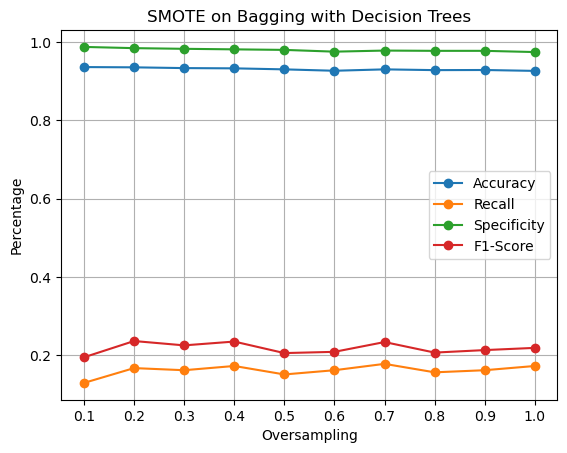

In [34]:
# BOOSTING BAGGING SMOTE
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

oversampling_percentages = np.arange(0.1, 1.1, 0.1)
print(oversampling_percentages)
accuracies = []
recalls = []
specificities = []
f1Scores = []

class_0 = int(len(y_train[y_train == 0]))
class_1 = int(len(y_train[y_train == 1]))
print('*' * 50)
print(class_0)
print(class_1)
print('*' * 50)

results_df = pd.DataFrame(columns=['Oversampling', 'Accuracy', 'Recall', 'Specificity', 'F1-Score'])

for oversample_percentage in oversampling_percentages:
    print()
    print('#' * 30)
    print(f'Oversampling Percentage: {oversample_percentage}%')
    print(f'Count of 0: {class_0}')
    print(f'Count of 1: {class_0 * oversample_percentage}')

    smote = SMOTE(sampling_strategy={0: class_0, 1: round(class_0 * oversample_percentage)}, random_state=42)
    x_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    base_classifier = DecisionTreeClassifier(random_state=42)
    xgb_classifier = BaggingClassifier(base_classifier, n_estimators=10, random_state=42)

    xgb_classifier.fit(x_train_smote, y_train_smote)

    y_pred = xgb_classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    recall = recall_score(y_test, y_pred)
    recalls.append(recall)

    conf_matrix = confusion_matrix(y_test, y_pred)
    true_negative = conf_matrix[0, 0]
    false_positive = conf_matrix[0, 1]
    specificity = true_negative / (true_negative + false_positive)
    specificities.append(specificity)

    f1Scores.append(f1_score(y_test, y_pred))

    print(y_train_smote.value_counts())
    print('#' * 30)
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'Specificity: {specificity:.4f}')
    print(f'F1-Score: {f1_score(y_test, y_pred):.4f}')
    print('-' * 30)

    results_df = results_df.append({
        'Oversampling': oversample_percentage,
        'Accuracy': accuracy,
        'Recall': recall,
        'Specificity': specificity,
        'F1-Score': f1_score(y_test, y_pred)
    }, ignore_index=True)

plt.plot(oversampling_percentages, accuracies, marker='o', label='Accuracy')
plt.plot(oversampling_percentages, recalls, marker='o', label='Recall')
plt.plot(oversampling_percentages, specificities, marker='o', label='Specificity')
plt.plot(oversampling_percentages, f1Scores, marker='o', label='F1-Score')
plt.title('SMOTE on Bagging with Decision Trees')
plt.xlabel('Oversampling')
plt.ylabel('Percentage')
plt.xticks(oversampling_percentages)
plt.legend()
plt.grid(True)
plt.show()

results_df.to_csv('results_DecisionTree_SMOTE345.csv', index=False)


0    11597
1      738
Name: FraudFound_P, dtype: int64
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
**************************************************
11597
738
**************************************************

##############################
Undersampling Percentage: 10.0%
Count of 0: 7380
Count of 1: 738
0    7380
1     738
Name: FraudFound_P, dtype: int64
##############################
Accuracy: 0.9345
Recall: 0.1730
Specificity: 0.9831
F1-Score: 0.2406
------------------------------

##############################
Undersampling Percentage: 20.0%
Count of 0: 3690
Count of 1: 738
0    3690
1     738
Name: FraudFound_P, dtype: int64
##############################
Accuracy: 0.8979
Recall: 0.2811
Specificity: 0.9372
F1-Score: 0.2482
------------------------------

##############################
Undersampling Percentage: 30.000000000000004%
Count of 0: 2460
Count of 1: 738
0    2460
1     738
Name: FraudFound_P, dtype: int64
##############################
Accuracy: 0.8635
Recall: 0.3189
Specificit

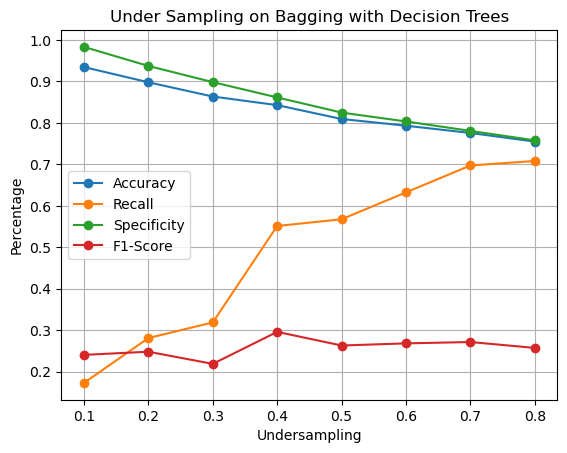

In [35]:
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, f1_score
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

print(y_train.value_counts())

undersampling_percentages = np.arange(0.1, 0.9, 0.1)
print(undersampling_percentages)
accuracies = []
recalls = []
specificities = []
f1Scores = []

class_0 = int(len(y_train[y_train == 0]))
class_1 = int(len(y_train[y_train == 1]))
print('*' * 50)
print(class_0)
print(class_1)
print('*' * 50)

results_df = pd.DataFrame(columns=['Oversampling', 'Accuracy', 'Recall', 'Specificity', 'F1-Score'])

for undersample_percentage in undersampling_percentages:
    print()
    print('#' * 30)
    print(f'Undersampling Percentage: {undersample_percentage * 100}%')
    print(f'Count of 0: {round(class_1 / undersample_percentage)}')
    print(f'Count of 1: {class_1}')

    undersampler = RandomUnderSampler(sampling_strategy={0: round(class_1 / undersample_percentage), 1: class_1}, random_state=42)
    x_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

    base_classifier = DecisionTreeClassifier(random_state=42)
    xgb_classifier = BaggingClassifier(base_classifier, n_estimators=10, random_state=42)

    xgb_classifier.fit(x_train_undersampled, y_train_undersampled)

    y_pred = xgb_classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    recall = recall_score(y_test, y_pred)
    recalls.append(recall)

    conf_matrix = confusion_matrix(y_test, y_pred)
    true_negative = conf_matrix[0, 0]
    false_positive = conf_matrix[0, 1]
    specificity = true_negative / (true_negative + false_positive)
    specificities.append(specificity)

    f1Scores.append(f1_score(y_test, y_pred))

    print(y_train_undersampled.value_counts())
    print('#' * 30)
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'Specificity: {specificity:.4f}')
    print(f'F1-Score: {f1_score(y_test, y_pred):.4f}')
    print('-' * 30)

    results_df = results_df.append({
        'Oversampling': oversample_percentage,
        'Accuracy': accuracy,
        'Recall': recall,
        'Specificity': specificity,
        'F1-Score': f1_score(y_test, y_pred)
    }, ignore_index=True)

# Plotting the results
plt.plot(undersampling_percentages, accuracies, marker='o', label='Accuracy')
plt.plot(undersampling_percentages, recalls, marker='o', label='Recall')
plt.plot(undersampling_percentages, specificities, marker='o', label='Specificity')
plt.plot(undersampling_percentages, f1Scores, marker='o', label='F1-Score')
plt.title('Under Sampling on Bagging with Decision Trees')
plt.xlabel('Undersampling')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True)
plt.show()


results_df.to_csv('results_DecisionTree_SMOTE.csv', index=False)


In [36]:
# Bagging HYBRID

import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, f1_score
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

oversampling_percentages = np.arange(0.1, 1.1, 0.1)
undersampling_percentages = np.arange(0.1, 0.9, 0.1)

results_df = pd.DataFrame(columns=['Oversampling', 'Undersampling', 'Accuracy', 'Recall', 'Specificity', 'F1-Score'])

best_combination = None
best_recall = 0
best_accuracy = 0
best_specificity = 0
best_f1 = 0

class_0 = int(len(y_train[y_train == 0]))
class_1 = int(len(y_train[y_train == 1]))

print(y_train.value_counts())

for oversample_percentage in oversampling_percentages:
    smote = SMOTE(sampling_strategy={0: class_0, 1: round(class_0 * oversample_percentage)}, random_state=42)
    x_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    print('*' * 50)
    print(y_train_smote.value_counts())
    print('*' * 50)
    print()

    class_1_first = int(len(y_train_smote[y_train_smote == 1]))

    for undersample_percentage in undersampling_percentages:
        undersampler = RandomUnderSampler(sampling_strategy={0: round(class_1 / undersample_percentage), 1: class_1_first}, random_state=42)
        x_train_hybrid, y_train_hybrid = undersampler.fit_resample(x_train_smote, y_train_smote)

        print('-' * 75)
        print('?' * 50)
        print(y_train_hybrid.value_counts())
        print('?' * 50)

        base_classifier = DecisionTreeClassifier(random_state=42)
        xgb_classifier = BaggingClassifier(base_classifier, n_estimators=10, random_state=42)

        xgb_classifier.fit(x_train_hybrid, y_train_hybrid)

        y_pred = xgb_classifier.predict(X_test)

        recall = recall_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)

        conf_matrix = confusion_matrix(y_test, y_pred)
        true_negative = conf_matrix[0, 0]
        false_positive = conf_matrix[0, 1]
        specificity = true_negative / (true_negative + false_positive)
        f1 = f1_score(y_test, y_pred)

        if recall > best_recall:
            best_recall = recall
            best_accuracy = accuracy
            best_specificity = specificity
            best_f1 = f1_score(y_test, y_pred)
            best_combination = (oversample_percentage, undersample_percentage)

        print(f'Oversampling Percentage: {oversample_percentage * 100}%')
        print(f'Undersampling Percentage: {undersample_percentage * 100}%')
        print(f'Recall: {recall:.4f}')
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Specificity: {specificity:.4f}')
        print(f'F1-Score: {f1:.4f}')
        print('-' * 30)

        results_df = results_df.append({
            'Oversampling': oversample_percentage,
            'Undersampling': undersample_percentage,
            'Accuracy': accuracy,
            'Recall': recall,
            'Specificity': specificity,
            'F1-Score': f1
        }, ignore_index=True)


print(f'Best Combination: Oversample {best_combination[0] * 100}%, Undersample {best_combination[1] * 100}%')
print(f'Best Recall: {best_recall:.4f}')
print(f'Best Accuracy: {best_accuracy:.4f}')
print(f'Best Specificity: {best_specificity:.4f}')
print(f'Best F1: {best_f1:.4f}')

# Save the DataFrame to a CSV file
results_df.to_csv('results_hyridBagging.csv', index=False)

0    11597
1      738
Name: FraudFound_P, dtype: int64
**************************************************
0    11597
1     1160
Name: FraudFound_P, dtype: int64
**************************************************

---------------------------------------------------------------------------
??????????????????????????????????????????????????
0    7380
1    1160
Name: FraudFound_P, dtype: int64
??????????????????????????????????????????????????
Oversampling Percentage: 10.0%
Undersampling Percentage: 10.0%
Recall: 0.1568
Accuracy: 0.9274
Specificity: 0.9765
F1-Score: 0.2057
------------------------------
---------------------------------------------------------------------------
??????????????????????????????????????????????????
0    3690
1    1160
Name: FraudFound_P, dtype: int64
??????????????????????????????????????????????????
Oversampling Percentage: 10.0%
Undersampling Percentage: 20.0%
Recall: 0.4054
Accuracy: 0.8949
Specificity: 0.9262
F1-Score: 0.3165
------------------------------

# Naive Bayes

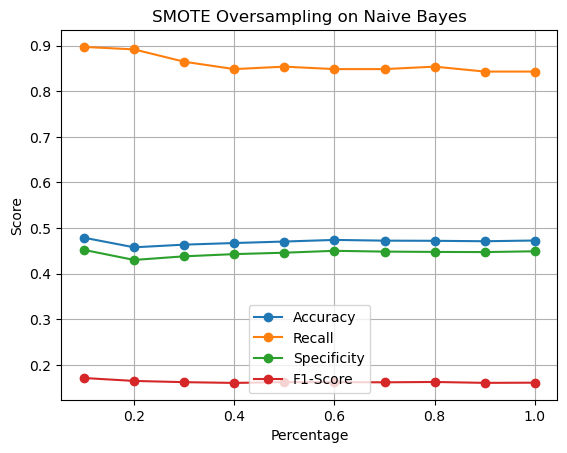

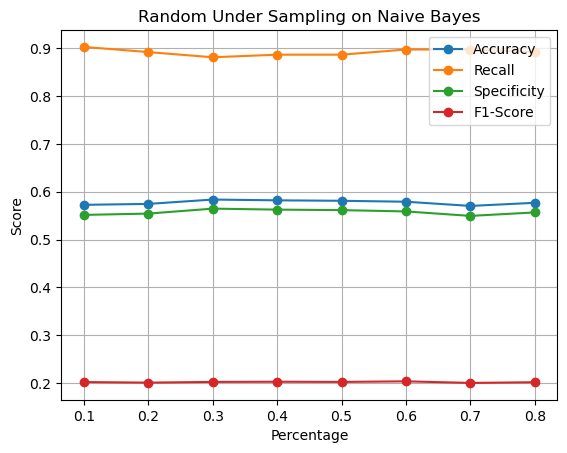

In [37]:
# NB SMOTE
oversampling_percentages = np.arange(0.1, 1.1, 0.1)
accuracies, recalls, specificities, f1_scores = [], [], [], []
nb_classifier = GaussianNB()

for oversample_percentage in oversampling_percentages:
    accuracy, recall, specificity, f1 = apply_smote(X_train, y_train, X_test, y_test, oversample_percentage, nb_classifier)
    accuracies.append(accuracy)
    recalls.append(recall)
    specificities.append(specificity)
    f1_scores.append(f1)

plot_results(oversampling_percentages, accuracies, recalls, specificities, f1_scores, 'SMOTE Oversampling on Naive Bayes')

# NB Under Sampling
undersampling_percentages = np.arange(0.1, 0.9, 0.1)
accuracies, recalls, specificities, f1_scores = [], [], [], []

for undersample_percentage in undersampling_percentages:
    accuracy, recall, specificity, f1 = apply_random_undersampling(X_train, y_train, X_test, y_test, undersample_percentage, nb_classifier)
    accuracies.append(accuracy)
    recalls.append(recall)
    specificities.append(specificity)
    f1_scores.append(f1)

plot_results(undersampling_percentages, accuracies, recalls, specificities, f1_scores, 'Random Under Sampling on Naive Bayes')

In [38]:
# NB HYBRID
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix

# Initialize empty lists to store results
oversampling_percentages = np.arange(0.1, 1.1, 0.1)
undersampling_percentages = np.arange(0.1, 0.9, 0.1)

results_df = pd.DataFrame(columns=['Oversampling', 'Undersampling', 'Accuracy', 'Recall', 'Specificity', 'F1-Score'])

best_combination = None
best_recall = 0
best_accuracy = 0
best_specificity = 0
best_f1 = 0

class_0 = int(len(y_train[y_train == 0]))
class_1 = int(len(y_train[y_train == 1]))

print(y_train.value_counts())

for oversample_percentage in oversampling_percentages:
    smote = SMOTE(sampling_strategy={0: class_0, 1: round(class_0 * oversample_percentage)}, random_state=42)
    x_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    print('*' * 50)
    print(y_train_smote.value_counts())
    print('*' * 50)
    print()
    class_1_first = int(len(y_train_smote[y_train_smote == 1]))

    for undersample_percentage in undersampling_percentages:
        undersampler = RandomUnderSampler(sampling_strategy={0: round(class_1 / undersample_percentage), 1: class_1_first}, random_state=42)
        x_train_hybrid, y_train_hybrid = undersampler.fit_resample(x_train_smote, y_train_smote)
        print('-' * 75)
        print('?' * 50)
        print(y_train_hybrid.value_counts())
        print('?' * 50)
        nb_classifier = GaussianNB()
        nb_classifier.fit(x_train_hybrid, y_train_hybrid)
        y_pred = nb_classifier.predict(X_test)

        recall = recall_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)

        conf_matrix = confusion_matrix(y_test, y_pred)
        true_negative = conf_matrix[0, 0]
        false_positive = conf_matrix[0, 1]
        specificity = true_negative / (true_negative + false_positive)

        f1 = f1_score(y_test, y_pred)

        if recall > best_recall:
            best_recall = recall
            best_accuracy = accuracy
            best_specificity = specificity
            best_f1 = f1_score(y_test, y_pred)
            best_combination = (oversample_percentage, undersample_percentage)

        results_df = results_df.append({
            'Oversampling': oversample_percentage,
            'Undersampling': undersample_percentage,
            'Accuracy': accuracy,
            'Recall': recall,
            'Specificity': specificity,
            'F1-Score': f1
        }, ignore_index=True)

        print(f'Oversampling Percentage: {oversample_percentage * 100}%')
        print(f'Undersampling Percentage: {undersample_percentage * 100}%')
        print(f'Recall: {recall:.4f}')
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Specificity: {specificity:.4f}')
        print(f'F1-Score: {f1:.4f}')
        print('-' * 30)

print(f'Best Combination: Oversample {best_combination[0] * 100}%, Undersample {best_combination[1] * 100}%')
print(f'Best Recall: {best_recall:.4f}')
print(f'Best Accuracy: {best_accuracy:.4f}')
print(f'Best Specificity: {best_specificity:.4f}')
print(f'Best F1: {best_f1:.4f}')

results_df.to_csv('results_hyridNB.csv', index=False)


0    11597
1      738
Name: FraudFound_P, dtype: int64
**************************************************
0    11597
1     1160
Name: FraudFound_P, dtype: int64
**************************************************

---------------------------------------------------------------------------
??????????????????????????????????????????????????
0    7380
1    1160
Name: FraudFound_P, dtype: int64
??????????????????????????????????????????????????
Oversampling Percentage: 10.0%
Undersampling Percentage: 10.0%
Recall: 0.8973
Accuracy: 0.4575
Specificity: 0.4295
F1-Score: 0.1656
------------------------------
---------------------------------------------------------------------------
??????????????????????????????????????????????????
0    3690
1    1160
Name: FraudFound_P, dtype: int64
??????????????????????????????????????????????????
Oversampling Percentage: 10.0%
Undersampling Percentage: 20.0%
Recall: 0.8973
Accuracy: 0.4818
Specificity: 0.4553
F1-Score: 0.1720
------------------------------

# Logistic Regression

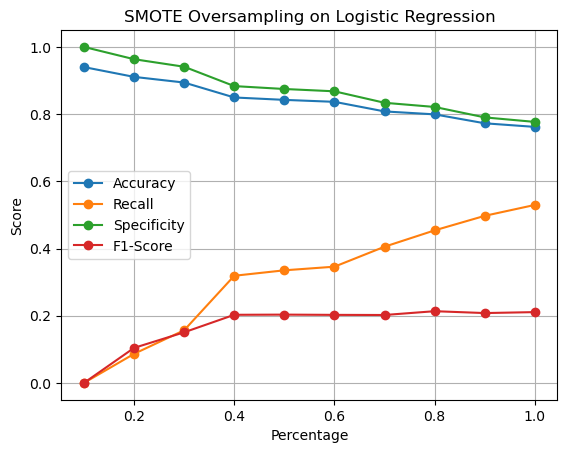

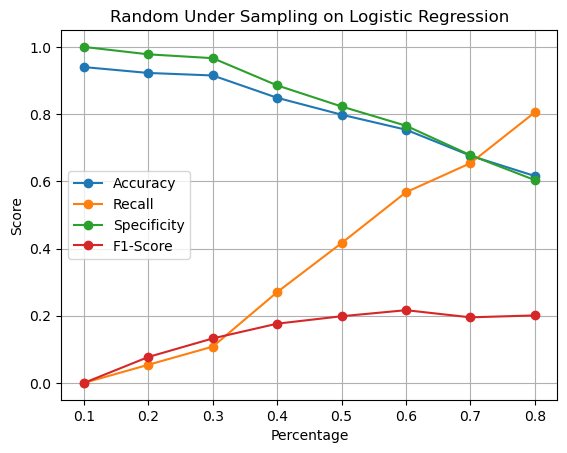

In [39]:
# NB SMOTE
oversampling_percentages = np.arange(0.1, 1.1, 0.1)
accuracies, recalls, specificities, f1_scores = [], [], [], []
nb_classifier = LogisticRegression()

for oversample_percentage in oversampling_percentages:
    accuracy, recall, specificity, f1 = apply_smote(X_train, y_train, X_test, y_test, oversample_percentage, nb_classifier)
    accuracies.append(accuracy)
    recalls.append(recall)
    specificities.append(specificity)
    f1_scores.append(f1)

plot_results(oversampling_percentages, accuracies, recalls, specificities, f1_scores, 'SMOTE Oversampling on Logistic Regression')

# NB Under Sampling
undersampling_percentages = np.arange(0.1, 0.9, 0.1)
accuracies, recalls, specificities, f1_scores = [], [], [], []

for undersample_percentage in undersampling_percentages:
    accuracy, recall, specificity, f1 = apply_random_undersampling(X_train, y_train, X_test, y_test, undersample_percentage, nb_classifier)
    accuracies.append(accuracy)
    recalls.append(recall)
    specificities.append(specificity)
    f1_scores.append(f1)

plot_results(undersampling_percentages, accuracies, recalls, specificities, f1_scores, 'Random Under Sampling on Logistic Regression')

In [40]:
# LR Hybrid
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix

# Assuming X_train, X_test, y_train, y_test are already defined

# Initialize empty lists to store results
oversampling_percentages = np.arange(0.1, 1.1, 0.1)
undersampling_percentages = np.arange(0.1, 0.9, 0.1)

results_df = pd.DataFrame(columns=['Oversampling', 'Undersampling', 'Accuracy', 'Recall', 'Specificity', 'F1-Score'])

best_combination = None
best_recall = 0
best_accuracy = 0
best_specificity = 0
best_f1 = 0

class_0 = int(len(y_train[y_train == 0]))
class_1 = int(len(y_train[y_train == 1]))

print(y_train.value_counts())

for oversample_percentage in oversampling_percentages:
    smote = SMOTE(sampling_strategy={0: class_0, 1: round(class_0 * oversample_percentage)}, random_state=42)
    x_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    print('*' * 50)
    print(y_train_smote.value_counts())
    print('*' * 50)
    print()

    class_1_first = int(len(y_train_smote[y_train_smote == 1]))

    for undersample_percentage in undersampling_percentages:
        
        undersampler = RandomUnderSampler(sampling_strategy={0: round(class_1 / undersample_percentage), 1: class_1_first}, random_state=42)
        x_train_hybrid, y_train_hybrid = undersampler.fit_resample(x_train_smote, y_train_smote)
        print('-' * 75)
        print('?' * 50)
        print(y_train_hybrid.value_counts())
        print('?' * 50)
        lr_classifier = LogisticRegression(random_state=42)

        lr_classifier.fit(x_train_hybrid, y_train_hybrid)

        y_pred = lr_classifier.predict(X_test)

        recall = recall_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)

        conf_matrix = confusion_matrix(y_test, y_pred)
        true_negative = conf_matrix[0, 0]
        false_positive = conf_matrix[0, 1]
        specificity = true_negative / (true_negative + false_positive)

        f1 = f1_score(y_test, y_pred)

        if recall > best_recall:
            best_recall = recall
            best_accuracy = accuracy
            best_specificity = specificity
            best_f1 = f1_score(y_test, y_pred)
            best_combination = (oversample_percentage, undersample_percentage)

        print(f'Oversampling Percentage: {oversample_percentage * 100}%')
        print(f'Undersampling Percentage: {undersample_percentage * 100}%')
        print(f'Recall: {recall:.4f}')
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Specificity: {specificity:.4f}')
        print(f'F1-Score: {f1:.4f}')
        print('-' * 30)

        results_df = results_df.append({
            'Oversampling': oversample_percentage,
            'Undersampling': undersample_percentage,
            'Accuracy': accuracy,
            'Recall': recall,
            'Specificity': specificity,
            'F1-Score': f1
        }, ignore_index=True)

print(f'Best Combination: Oversample {best_combination[0] * 100}%, Undersample {best_combination[1] * 100}%')
print(f'Best Recall: {best_recall:.4f}')
print(f'Best Accuracy: {best_accuracy:.4f}')
print(f'Best Specificity: {best_specificity:.4f}')
print(f'Best F1: {best_f1:.4f}')

results_df.to_csv('results_hyridLR.csv', index=False)


0    11597
1      738
Name: FraudFound_P, dtype: int64
**************************************************
0    11597
1     1160
Name: FraudFound_P, dtype: int64
**************************************************

---------------------------------------------------------------------------
??????????????????????????????????????????????????
0    7380
1    1160
Name: FraudFound_P, dtype: int64
??????????????????????????????????????????????????
Oversampling Percentage: 10.0%
Undersampling Percentage: 10.0%
Recall: 0.0108
Accuracy: 0.9384
Specificity: 0.9976
F1-Score: 0.0206
------------------------------
---------------------------------------------------------------------------
??????????????????????????????????????????????????
0    3690
1    1160
Name: FraudFound_P, dtype: int64
??????????????????????????????????????????????????
Oversampling Percentage: 10.0%
Undersampling Percentage: 20.0%
Recall: 0.1892
Accuracy: 0.9011
Specificity: 0.9465
F1-Score: 0.1867
------------------------------

In [41]:
end = time.time()
print(end-start)
print(f"Execution time: {(end-start)/60:.2f} minutes")

117.71394848823547
Execution time: 1.96 minutes
